# ========================================
# Imports
# ========================================

In [1]:
import os
import random
import argparse
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms


from tqdm.notebook import tqdm as tqdm_notebook
tqdm = tqdm_notebook
from sklearn.model_selection import train_test_split

import sys

sys.argv = ['']

print("Imports OK")

Imports OK


# ========================================
# Dataset
# ========================================

In [2]:
class SignaturePairsDataset(Dataset):
    def __init__(self, root_dir, transform=None, num_pairs=5000, seed=42):
        self.root_dir = root_dir
        self.transform = transform
        self.num_pairs = num_pairs
        self.rng = random.Random(seed)

        persons = [d for d in sorted(os.listdir(root_dir)) if os.path.isdir(os.path.join(root_dir, d))]
        self.data = {}
        for p in persons:
            files = sorted([
                os.path.join(root_dir, p, f) for f in os.listdir(os.path.join(root_dir, p))
                if f.lower().endswith((".png", ".jpg", ".jpeg", ".tif", ".bmp"))
            ])
            if len(files) >= 2:
                self.data[p] = files

        self.persons = list(self.data.keys())
        if len(self.persons) < 2:
            raise RuntimeError(f"Need >=2 persons with >=2 images each in {root_dir}")

        print(f"Found {len(self.persons)} persons with >=2 images each.")

    def __len__(self):
        return self.num_pairs

    def __getitem__(self, idx):
        if self.rng.random() < 0.5:
            p = self.rng.choice(self.persons)
            a, b = self.rng.sample(self.data[p], 2)
            label = 1.0
        else:
            p1, p2 = self.rng.sample(self.persons, 2)
            a = self.rng.choice(self.data[p1])
            b = self.rng.choice(self.data[p2])
            label = 0.0

        img_a = Image.open(a)
        img_b = Image.open(b)

        if self.transform:
            img_a = self.transform(img_a)
            img_b = self.transform(img_b)

        return img_a, img_b, torch.tensor(label, dtype=torch.float32)

print("Dataset class defined")

Dataset class defined


# ========================================
#  Split train/val par personne
# ========================================

In [4]:
"""def split_dataset(root_dir, val_ratio=0.2, seed=42):
    persons = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
    valid_persons = []
    for p in persons:
        path = os.path.join(root_dir, p)
        files = [f for f in os.listdir(path) if f.lower().endswith((".png", ".jpg", ".jpeg", ".tif", ".bmp"))]
        if len(files) >= 2:
            valid_persons.append(p)
    
    train_persons, val_persons = train_test_split(
        valid_persons, test_size=val_ratio, random_state=seed
    )
    print(f"Total persons with >=2 images: {len(valid_persons)}")
    print(f"→ Train: {len(train_persons)} | Val: {len(val_persons)}")
    return train_persons, val_persons

# CONFIG
ROOT_DIR = '/home/marco/Projet_du_Fin_DEtude_M2/Datasets/sign_data/train'  
train_persons, val_persons = split_dataset(ROOT_DIR, val_ratio=0.2)"""

'def split_dataset(root_dir, val_ratio=0.2, seed=42):\n    persons = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]\n    valid_persons = []\n    for p in persons:\n        path = os.path.join(root_dir, p)\n        files = [f for f in os.listdir(path) if f.lower().endswith((".png", ".jpg", ".jpeg", ".tif", ".bmp"))]\n        if len(files) >= 2:\n            valid_persons.append(p)\n\n    train_persons, val_persons = train_test_split(\n        valid_persons, test_size=val_ratio, random_state=seed\n    )\n    print(f"Total persons with >=2 images: {len(valid_persons)}")\n    print(f"→ Train: {len(train_persons)} | Val: {len(val_persons)}")\n    return train_persons, val_persons\n\n# CONFIG\nROOT_DIR = \'/home/marco/Projet_du_Fin_DEtude_M2/Datasets/sign_data/train\'  \ntrain_persons, val_persons = split_dataset(ROOT_DIR, val_ratio=0.2)'

# ========================================
#  Dataset
# ========================================

In [5]:
"""class SignaturePairsDataset(Dataset):
    def __init__(self, root_dir, allowed_persons, transform=None, num_pairs=5000, seed=42):
        self.root_dir = root_dir
        self.transform = transform
        self.num_pairs = num_pairs
        self.rng = random.Random(seed)

        self.data = {}
        for p in allowed_persons:
            path = os.path.join(root_dir, p)
            files = [
                os.path.join(path, f) for f in os.listdir(path)
                if f.lower().endswith((".png", ".jpg", ".jpeg", ".tif", ".bmp"))
            ]
            if len(files) >= 2:
                self.data[p] = sorted(files)

        self.persons = list(self.data.keys())
        if len(self.persons) < 2:
            raise RuntimeError("Not enough persons with 2+ images in allowed list")

        total_imgs = sum(len(v) for v in self.data.values())
        print(f"Dataset: {len(self.persons)} persons, {total_imgs} images, {num_pairs} pairs")

    def __len__(self):
        return self.num_pairs

    def __getitem__(self, idx):
        if self.rng.random() < 0.5:
            p = self.rng.choice(self.persons)
            a, b = self.rng.sample(self.data[p], 2)
            label = 1.0
        else:
            p1, p2 = self.rng.sample(self.persons, 2)
            a = self.rng.choice(self.data[p1])
            b = self.rng.choice(self.data[p2])
            label = 0.0

        img_a = Image.open(a)
        img_b = Image.open(b)
        if self.transform:
            img_a = self.transform(img_a)
            img_b = self.transform(img_b)
        return img_a, img_b, torch.tensor(label, dtype=torch.float32)

print("Dataset class ready")"""

'class SignaturePairsDataset(Dataset):\n    def __init__(self, root_dir, allowed_persons, transform=None, num_pairs=5000, seed=42):\n        self.root_dir = root_dir\n        self.transform = transform\n        self.num_pairs = num_pairs\n        self.rng = random.Random(seed)\n\n        self.data = {}\n        for p in allowed_persons:\n            path = os.path.join(root_dir, p)\n            files = [\n                os.path.join(path, f) for f in os.listdir(path)\n                if f.lower().endswith((".png", ".jpg", ".jpeg", ".tif", ".bmp"))\n            ]\n            if len(files) >= 2:\n                self.data[p] = sorted(files)\n\n        self.persons = list(self.data.keys())\n        if len(self.persons) < 2:\n            raise RuntimeError("Not enough persons with 2+ images in allowed list")\n\n        total_imgs = sum(len(v) for v in self.data.values())\n        print(f"Dataset: {len(self.persons)} persons, {total_imgs} images, {num_pairs} pairs")\n\n    def __len__(sel

# ========================================
# Modèle Siamois CNN
# ========================================

In [3]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, pool=True):
        super().__init__()
        layers = [
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        ]
        if pool:
            layers.append(nn.MaxPool2d(2))
        self.block = nn.Sequential(*layers)
    def forward(self, x):
        return self.block(x)

class LightweightSiamese(nn.Module):
    def __init__(self, embedding_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            ConvBlock(1, 32),     # 224 -> 112
            ConvBlock(32, 64),    # 112 -> 56
            ConvBlock(64, 128),   # 56  -> 28
            ConvBlock(128, 256),  # 28  -> 14
            ConvBlock(256, 256, pool=False),
            nn.AdaptiveAvgPool2d((1, 1)),
        )
        self.fc = nn.Linear(256, embedding_dim)

    def forward_once(self, x):
        x = self.net(x)
        x = x.view(x.size(0), -1)
        emb = self.fc(x)
        emb = F.normalize(emb, p=2, dim=1)
        return emb

    def forward(self, x1, x2):
        return self.forward_once(x1), self.forward_once(x2)

print("Model defined")

Model defined


# ========================================
#  Loss + Validation
# ========================================

In [10]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin
    def forward(self, emb1, emb2, label):
        dist = F.pairwise_distance(emb1, emb2)
        loss_pos = label * dist.pow(2)
        loss_neg = (1 - label) * F.relu(self.margin - dist).pow(2)
        return (loss_pos + loss_neg).mean()

def compute_val_metrics(model, loader, device, threshold=0.7):
    model.eval()
    dists, labels = [], []
    with torch.no_grad():
        for img1, img2, lbl in loader:
            img1, img2, lbl = img1.to(device), img2.to(device), lbl.to(device)
            emb1, emb2 = model(img1, img2)
            dist = F.pairwise_distance(emb1, emb2)
            dists.append(dist.cpu().numpy())
            labels.append(lbl.cpu().numpy())
    dists = np.concatenate(dists).ravel()
    labels = np.concatenate(labels).ravel()
    preds = (dists < threshold).astype(float)
    acc = (preds == labels).mean() * 100.0
    pos_mean = dists[labels == 1].mean() if (labels == 1).any() else 0
    neg_mean = dists[labels == 0].mean() if (labels == 0).any() else 0
    return acc, pos_mean, neg_mean

print("Loss & metrics ready")

Loss & metrics ready


# ========================================
# Collate + Config
# ========================================

In [11]:
def siamese_collate_fn(batch):
    img1s = torch.stack([item[0] for item in batch])
    img2s = torch.stack([item[1] for item in batch])
    labels = torch.stack([item[2] for item in batch])
    return img1s, img2s, labels

# CONFIG (modifiable ici)
ROOT_DIR = '/home/marco/Projet_du_Fin_DEtude_M2/Datasets/sign_data/train'  # Change ici
EPOCHS = 50
BATCH_SIZE = 32
PAIRS_TRAIN = 10000
PAIRS_VAL = 10000
LR = 1e-3
SAVE_PATH = 'siamese.pth'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


# ========================================
# Transforms + Datasets + Loaders
# ========================================

In [12]:
IMG_SIZE = (224, 224)

train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(IMG_SIZE),
    transforms.RandomAffine(degrees=5, translate=(0.02, 0.02), shear=5),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 0.5)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_ds = SignaturePairsDataset(ROOT_DIR, transform=train_transform, num_pairs=PAIRS_TRAIN)
val_ds = SignaturePairsDataset(ROOT_DIR, transform=val_transform, num_pairs=PAIRS_VAL)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=2, pin_memory=True, collate_fn=siamese_collate_fn)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=2, pin_memory=True, collate_fn=siamese_collate_fn)

print(f"Train pairs: {len(train_ds)}, Val pairs: {len(val_ds)}")

Found 128 persons with >=2 images each.
Found 128 persons with >=2 images each.
Train pairs: 10000, Val pairs: 10000


# ========================================
# Modèle + Optimisation
# ========================================

In [13]:
model = LightweightSiamese(embedding_dim=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
criterion = ContrastiveLoss(margin=1.0)
scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' else None

print(f"Model on {device} | Params: {sum(p.numel() for p in model.parameters()):,}")

Model on cuda | Params: 1,011,552


# ========================================
# Boucle d'entraînement
# ========================================

In [14]:
history = {'loss': [], 'val_acc': [], 'pos_dist': [], 'neg_dist': []}

for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0
    n = 0
    for img1, img2, lbl in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}"):
        img1, img2, lbl = img1.to(device), img2.to(device), lbl.to(device)
        optimizer.zero_grad()

        if scaler:
            with torch.cuda.amp.autocast():
                emb1, emb2 = model(img1, img2)
                loss = criterion(emb1, emb2, lbl)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            emb1, emb2 = model(img1, img2)
            loss = criterion(emb1, emb2, lbl)
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * img1.size(0)
        n += img1.size(0)

    scheduler.step()
    epoch_loss = running_loss / n
    val_acc, pos_mean, neg_mean = compute_val_metrics(model, val_loader, device)

    history['loss'].append(epoch_loss)
    history['val_acc'].append(val_acc)
    history['pos_dist'].append(pos_mean)
    history['neg_dist'].append(neg_mean)

    print(f"Epoch {epoch:2d} | Loss: {epoch_loss:.4f} | Val Acc: {val_acc:5.2f}% "
          f"| Pos: {pos_mean:.3f} | Neg: {neg_mean:.3f} | LR: {scheduler.get_last_lr()[0]:.2e}")

# Sauvegarde
torch.save(model.state_dict(), SAVE_PATH)
print(f"\nModel saved to {SAVE_PATH}")

Epoch 1/50:   0%|          | 0/313 [00:00<?, ?it/s]

/home/marco/marco/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch  1 | Loss: 0.1175 | Val Acc: 79.10% | Pos: 0.255 | Neg: 0.793 | LR: 1.00e-03


Epoch 2/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch  2 | Loss: 0.0972 | Val Acc: 77.94% | Pos: 0.214 | Neg: 0.766 | LR: 1.00e-03


Epoch 3/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch  3 | Loss: 0.0868 | Val Acc: 71.74% | Pos: 0.195 | Neg: 0.669 | LR: 1.00e-03


Epoch 4/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch  4 | Loss: 0.0792 | Val Acc: 78.00% | Pos: 0.197 | Neg: 0.757 | LR: 1.00e-03


Epoch 5/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch  5 | Loss: 0.0737 | Val Acc: 73.29% | Pos: 0.178 | Neg: 0.688 | LR: 1.00e-03


Epoch 6/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch  6 | Loss: 0.0699 | Val Acc: 84.37% | Pos: 0.207 | Neg: 0.898 | LR: 1.00e-03


Epoch 7/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch  7 | Loss: 0.0665 | Val Acc: 78.87% | Pos: 0.191 | Neg: 0.780 | LR: 1.00e-03


Epoch 8/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch  8 | Loss: 0.0646 | Val Acc: 77.69% | Pos: 0.200 | Neg: 0.755 | LR: 1.00e-03


Epoch 9/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch  9 | Loss: 0.0623 | Val Acc: 88.31% | Pos: 0.233 | Neg: 0.994 | LR: 1.00e-03


Epoch 10/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 10 | Loss: 0.0604 | Val Acc: 90.10% | Pos: 0.224 | Neg: 1.071 | LR: 1.00e-03


Epoch 11/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 11 | Loss: 0.0583 | Val Acc: 91.88% | Pos: 0.219 | Neg: 1.075 | LR: 1.00e-03


Epoch 12/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 12 | Loss: 0.0572 | Val Acc: 92.45% | Pos: 0.217 | Neg: 1.106 | LR: 1.00e-03


Epoch 13/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 13 | Loss: 0.0555 | Val Acc: 90.26% | Pos: 0.215 | Neg: 1.056 | LR: 1.00e-03


Epoch 14/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 14 | Loss: 0.0528 | Val Acc: 91.81% | Pos: 0.206 | Neg: 1.097 | LR: 1.00e-03


Epoch 15/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 15 | Loss: 0.0511 | Val Acc: 91.35% | Pos: 0.190 | Neg: 1.070 | LR: 1.00e-03


Epoch 16/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 16 | Loss: 0.0502 | Val Acc: 93.26% | Pos: 0.197 | Neg: 1.143 | LR: 1.00e-03


Epoch 17/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 17 | Loss: 0.0481 | Val Acc: 94.43% | Pos: 0.192 | Neg: 1.151 | LR: 1.00e-03


Epoch 18/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 18 | Loss: 0.0453 | Val Acc: 93.78% | Pos: 0.188 | Neg: 1.134 | LR: 1.00e-03


Epoch 19/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 19 | Loss: 0.0436 | Val Acc: 92.30% | Pos: 0.195 | Neg: 1.108 | LR: 1.00e-03


Epoch 20/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 20 | Loss: 0.0421 | Val Acc: 95.32% | Pos: 0.197 | Neg: 1.185 | LR: 5.00e-04


Epoch 21/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 21 | Loss: 0.0356 | Val Acc: 95.63% | Pos: 0.183 | Neg: 1.196 | LR: 5.00e-04


Epoch 22/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 22 | Loss: 0.0330 | Val Acc: 95.69% | Pos: 0.171 | Neg: 1.178 | LR: 5.00e-04


Epoch 23/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 23 | Loss: 0.0306 | Val Acc: 95.03% | Pos: 0.164 | Neg: 1.165 | LR: 5.00e-04


Epoch 24/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 24 | Loss: 0.0291 | Val Acc: 95.04% | Pos: 0.166 | Neg: 1.155 | LR: 5.00e-04


Epoch 25/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 25 | Loss: 0.0272 | Val Acc: 94.15% | Pos: 0.162 | Neg: 1.127 | LR: 5.00e-04


Epoch 26/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 26 | Loss: 0.0256 | Val Acc: 93.58% | Pos: 0.154 | Neg: 1.124 | LR: 5.00e-04


Epoch 27/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 27 | Loss: 0.0243 | Val Acc: 94.54% | Pos: 0.159 | Neg: 1.163 | LR: 5.00e-04


Epoch 28/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 28 | Loss: 0.0230 | Val Acc: 95.34% | Pos: 0.160 | Neg: 1.193 | LR: 5.00e-04


Epoch 29/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 29 | Loss: 0.0216 | Val Acc: 94.80% | Pos: 0.154 | Neg: 1.156 | LR: 5.00e-04


Epoch 30/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 30 | Loss: 0.0205 | Val Acc: 96.27% | Pos: 0.160 | Neg: 1.229 | LR: 5.00e-04


Epoch 31/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 31 | Loss: 0.0202 | Val Acc: 96.51% | Pos: 0.161 | Neg: 1.234 | LR: 5.00e-04


Epoch 32/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 32 | Loss: 0.0197 | Val Acc: 96.85% | Pos: 0.169 | Neg: 1.244 | LR: 5.00e-04


Epoch 33/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 33 | Loss: 0.0190 | Val Acc: 96.53% | Pos: 0.177 | Neg: 1.256 | LR: 5.00e-04


Epoch 34/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 34 | Loss: 0.0181 | Val Acc: 95.13% | Pos: 0.175 | Neg: 1.195 | LR: 5.00e-04


Epoch 35/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 35 | Loss: 0.0173 | Val Acc: 94.92% | Pos: 0.178 | Neg: 1.192 | LR: 5.00e-04


Epoch 36/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 36 | Loss: 0.0171 | Val Acc: 97.68% | Pos: 0.151 | Neg: 1.270 | LR: 5.00e-04


Epoch 37/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 37 | Loss: 0.0164 | Val Acc: 97.92% | Pos: 0.154 | Neg: 1.286 | LR: 5.00e-04


Epoch 38/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 38 | Loss: 0.0157 | Val Acc: 97.14% | Pos: 0.158 | Neg: 1.245 | LR: 5.00e-04


Epoch 39/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 39 | Loss: 0.0156 | Val Acc: 97.76% | Pos: 0.154 | Neg: 1.267 | LR: 5.00e-04


Epoch 40/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 40 | Loss: 0.0154 | Val Acc: 97.71% | Pos: 0.141 | Neg: 1.284 | LR: 2.50e-04


Epoch 41/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 41 | Loss: 0.0140 | Val Acc: 97.74% | Pos: 0.140 | Neg: 1.297 | LR: 2.50e-04


Epoch 42/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 42 | Loss: 0.0124 | Val Acc: 98.02% | Pos: 0.137 | Neg: 1.312 | LR: 2.50e-04


Epoch 43/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 43 | Loss: 0.0118 | Val Acc: 98.32% | Pos: 0.137 | Neg: 1.319 | LR: 2.50e-04


Epoch 44/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 44 | Loss: 0.0112 | Val Acc: 98.42% | Pos: 0.131 | Neg: 1.333 | LR: 2.50e-04


Epoch 45/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 45 | Loss: 0.0108 | Val Acc: 98.40% | Pos: 0.127 | Neg: 1.339 | LR: 2.50e-04


Epoch 46/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 46 | Loss: 0.0105 | Val Acc: 98.46% | Pos: 0.125 | Neg: 1.336 | LR: 2.50e-04


Epoch 47/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 47 | Loss: 0.0101 | Val Acc: 98.58% | Pos: 0.126 | Neg: 1.340 | LR: 2.50e-04


Epoch 48/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 48 | Loss: 0.0098 | Val Acc: 98.54% | Pos: 0.123 | Neg: 1.328 | LR: 2.50e-04


Epoch 49/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 49 | Loss: 0.0096 | Val Acc: 98.66% | Pos: 0.126 | Neg: 1.342 | LR: 2.50e-04


Epoch 50/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 50 | Loss: 0.0095 | Val Acc: 98.72% | Pos: 0.123 | Neg: 1.331 | LR: 2.50e-04

Model saved to siamese.pth


# ========================================
# Visualisation des courbes
# ========================================

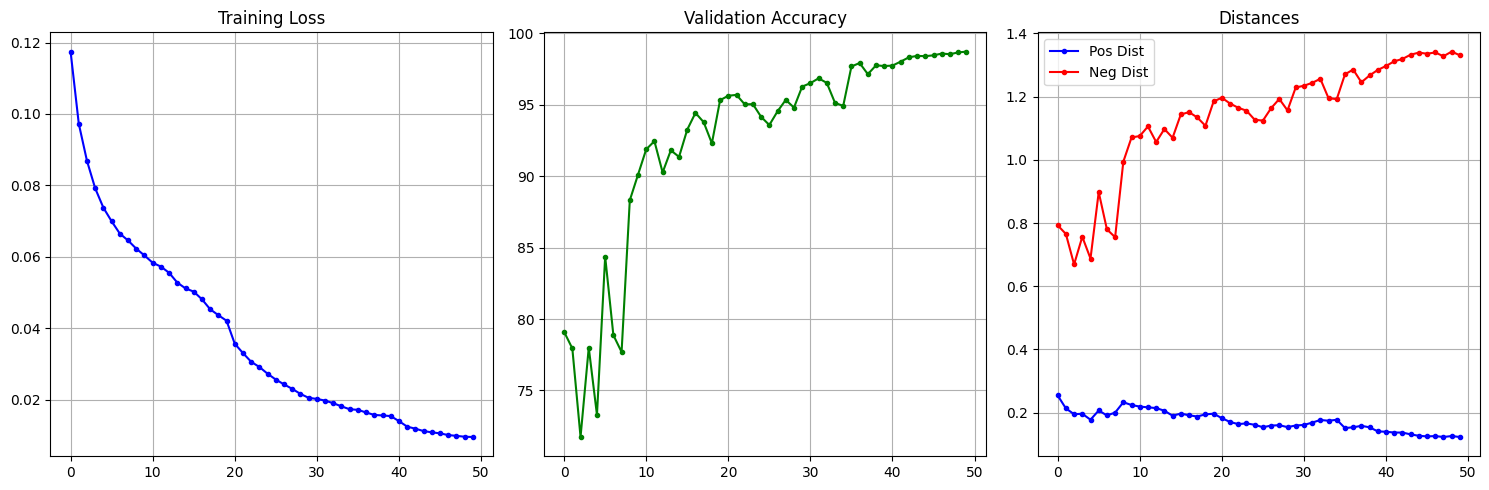

In [15]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history['loss'], 'b-o', markersize=3)
plt.title('Training Loss')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(history['val_acc'], 'g-o', markersize=3)
plt.title('Validation Accuracy')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(history['pos_dist'], 'b-o', label='Pos Dist', markersize=3)
plt.plot(history['neg_dist'], 'r-o', label='Neg Dist', markersize=3)
plt.title('Distances')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

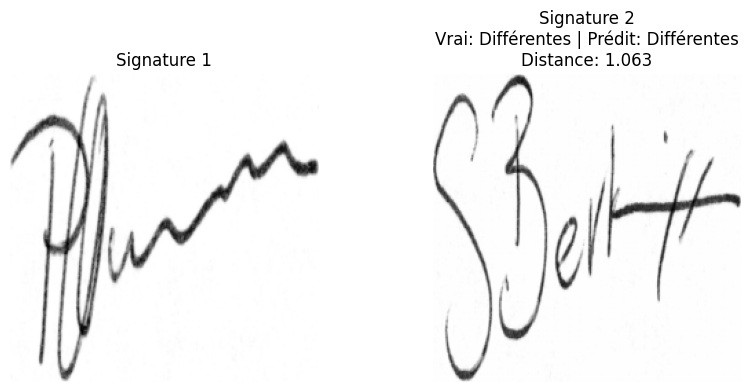

In [16]:
model.eval()
with torch.no_grad():
    img1, img2, lbl = next(iter(val_loader))
    img1, img2 = img1[:1].to(device), img2[:1].to(device)
    emb1, emb2 = model(img1, img2)
    dist = F.pairwise_distance(emb1, emb2).item()
    pred = "Même" if dist < 0.8 else "Différentes"
    true = "Même" if lbl[0] == 1 else "Différentes"

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img1[0].cpu().numpy().squeeze(), cmap='gray')
    plt.title("Signature 1")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img2[0].cpu().numpy().squeeze(), cmap='gray')
    plt.title(f"Signature 2\nVrai: {true} | Prédit: {pred}\nDistance: {dist:.3f}")
    plt.axis('off')
    plt.show()


# ========================================
#  Fonction compare() pour test manuel
# ========================================

In [19]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
from datetime import datetime
from ultralytics import YOLO


# Dossier de sauvegarde
SAVE_DIR = "comparison_tests"
os.makedirs(SAVE_DIR, exist_ok=True)




def compare(img_path1, img_path2, show_crops=True, save_plot=True):
    """
    Compare deux images de CIN ou signatures.
    - Détecte la signature avec YOLO si c'est une CIN
    - Sinon, traite directement l'image comme une signature
    - Affiche + sauvegarde le résultat
    """
    model.eval()
    
    def load_and_crop(path):
        """Charge une image et extrait la signature si c'est une CIN"""
        if not os.path.exists(path):
            print(f"Erreur : Fichier non trouvé : {path}")
            return None, None
        
        # Charger avec OpenCV pour YOLO
        img_cv = cv2.imread(path)
        if img_cv is None:
            print(f"Erreur : Impossible de charger {path}")
            return None, None
        
        # Détection YOLO
        yolo_model = YOLO("/home/marco/Projet_du_Fin_DEtude_M2/Models/Model_YOLO/runs/detect/train35/weights/best.pt")
        
        results = yolo_model.predict(path, save=False, verbose=False, conf=0.5)
        crop_path = None
        for result in results:
            if result.boxes is not None:
                for box in result.boxes:
                    cls = int(box.cls[0].item())
                    if yolo_model.names.get(cls) == "signature":
                        x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
                        cropped = img_cv[y1:y2, x1:x2]
                        # Sauvegarde temporaire
                        temp_path = os.path.join(SAVE_DIR, f"temp_crop_{os.urandom(4).hex()}.png")
                        cv2.imwrite(temp_path, cropped)
                        crop_path = temp_path
                        break
                if crop_path:
                    break
        
        # Si pas de détection → on utilise l'image entière (cas signature directe)
        if crop_path is None:
            print(f"Aucune signature détectée dans {os.path.basename(path)} → utilisation de l'image entière")
            pil_img = Image.open(path).convert("L")
            pil_img = pil_img.resize((224, 224))
            temp_path = os.path.join(SAVE_DIR, f"temp_full_{os.urandom(4).hex()}.png")
            pil_img.save(temp_path)
            crop_path = temp_path
        
        return crop_path, img_cv

    # Charger et extraire
    print("Extraction des signatures...")
    sig1_path, img1_cv = load_and_crop(img_path1)
    sig2_path, img2_cv = load_and_crop(img_path2)
    
    if not sig1_path or not sig2_path:
        print("Erreur lors de l'extraction.")
        return

    # Transformer pour le modèle

    import torchvision.transforms as transforms

# Transformation pour le modèle Siamese (doit être identique à l'entraînement)
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    img1_pil = Image.open(sig1_path).convert("L")
    img2_pil = Image.open(sig2_path).convert("L")
    
    t1 = transform(img1_pil).unsqueeze(0).to(device)
    t2 = transform(img2_pil).unsqueeze(0).to(device)

    # Inférence
    with torch.no_grad():
        emb1, emb2 = model(t1, t2)
        dist = F.pairwise_distance(emb1, emb2).item()

    threshold = 0.8
    pred = "Même personne" if dist < threshold else "Personnes différentes"
    color = 'green' if dist < threshold else 'red'

    # === AFFICHAGE ===
    if show_crops:
        plt.figure(figsize=(14, 6))

        # Image originale 1
        plt.subplot(2, 3, 1)
        img1_rgb = cv2.cvtColor(img1_cv, cv2.COLOR_BGR2RGB)
        plt.imshow(img1_rgb)
        plt.title(f"CIN 1\n{os.path.basename(img_path1)}", fontsize=10)
        plt.axis('off')

        # Signature extraite 1
        plt.subplot(2, 3, 2)
        plt.imshow(img1_pil, cmap='gray')
        plt.title("Signature extraite", fontsize=10)
        plt.axis('off')

        # Image originale 2
        plt.subplot(2, 3, 4)
        img2_rgb = cv2.cvtColor(img2_cv, cv2.COLOR_BGR2RGB)
        plt.imshow(img2_rgb)
        plt.title(f"CIN 2\n{os.path.basename(img_path2)}", fontsize=10)
        plt.axis('off')

        # Signature extraite 2
        plt.subplot(2, 3, 5)
        plt.imshow(img2_pil, cmap='gray')
        plt.title("Signature extraite", fontsize=10)
        plt.axis('off')

        # Résultat
        plt.subplot(2, 3, 3)
        plt.text(0.5, 0.6, pred, ha='center', va='center', fontsize=16, fontweight='bold', color=color)
        plt.text(0.5, 0.4, f"Distance: {dist:.3f}", ha='center', va='center', fontsize=12)
        plt.text(0.5, 0.3, f"Seuil: {threshold}", ha='center', va='center', fontsize=10, color='gray')
        plt.axis('off')
        plt.title("Résultat de la comparaison", fontsize=12, pad=20)

        plt.subplot(2, 3, 6)
        plt.text(0.5, 0.5, "YOLO + Siamese", ha='center', va='center', fontsize=10, color='gray')
        plt.axis('off')

        plt.suptitle("Comparaison de Signatures", fontsize=16, fontweight='bold')
        plt.tight_layout()

        # Sauvegarde
        if save_plot:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            save_path = f"{SAVE_DIR}/comparison_{timestamp}.png"
            plt.savefig(save_path, dpi=200, bbox_inches='tight', facecolor='white')
            print(f"Résultat sauvegardé : {save_path}")

        plt.show()

    else:
        print(f"Résultat : {pred} | Distance = {dist:.3f}")

    # Nettoyage des crops temporaires
    for p in [sig1_path, sig2_path]:
        if p and 'temp_' in p and os.path.exists(p):
            try:
                os.remove(p)
            except:
                pass

    return dist, pred

Extraction des signatures...
Aucune signature détectée dans 05.jpg → utilisation de l'image entière
Aucune signature détectée dans 16.jpeg → utilisation de l'image entière
Résultat sauvegardé : comparison_tests/comparison_20251118_100456.png


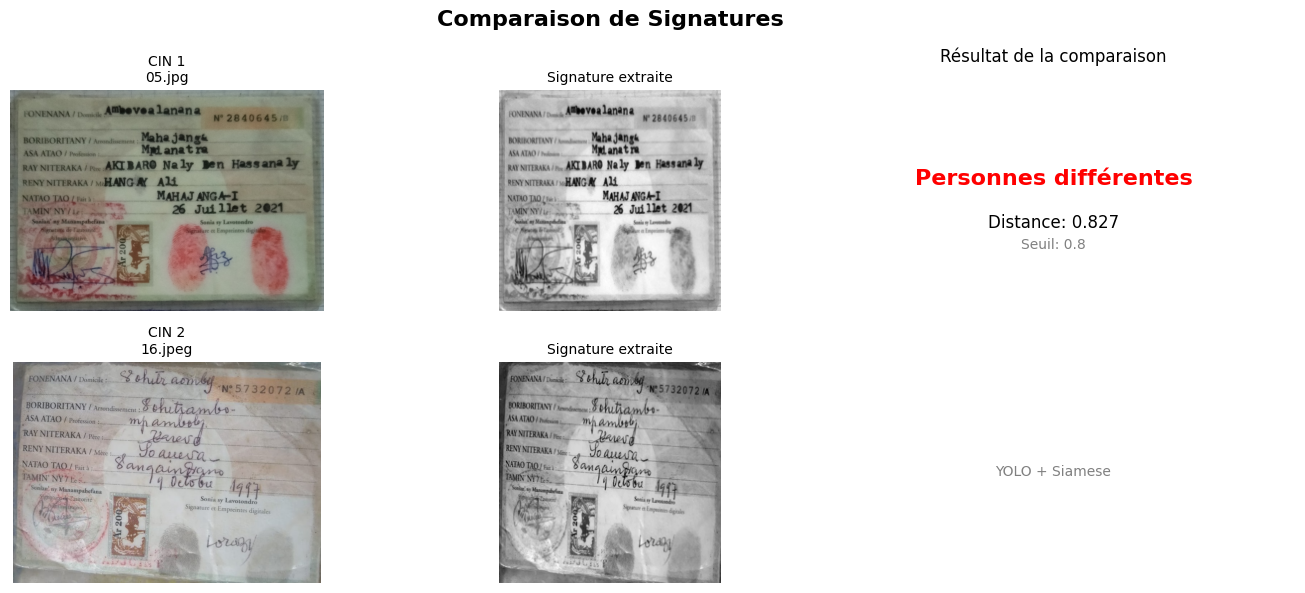

In [22]:
# Exemple de test
dist, pred = compare(
    "/home/marco/Projet_du_Fin_DEtude_M2/Datasets/CIN_data/images/test/05.jpg",
    "/home/marco/Projet_du_Fin_DEtude_M2/Datasets/CIN_data/images/test/16.jpeg"
)

In [25]:
import torch
import torch.nn.functional as F
from PIL import Image
import torchvision.transforms as transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Recharge ton modèle
model = LightweightSiamese().to(device)
model.load_state_dict(torch.load("/home/marco/Projet_du_Fin_DEtude_M2/Models/Model_siemese/siamese.pth", map_location=device))
model.eval()

# Transform (doit être IDENTIQUE à l'entraînement !)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])   # TRÈS IMPORTANT !
])

def compare(imgA_path, imgB_path, threshold=0.7):
    img1 = transform(Image.open(imgA_path)).unsqueeze(0).to(device)
    img2 = transform(Image.open(imgB_path)).unsqueeze(0).to(device)
    
    with torch.no_grad():
        emb1, emb2 = model(img1, img2)           # ← Deux embeddings
        distance = F.pairwise_distance(emb1, emb2).item()  # ← Vraie distance !

    print(f"Distance : {distance:.4f}")
    if distance < threshold:
        print("Même personne")
    else:
        print("Personnes différentes")
    
    return distance

# Test
compare(
    "/home/marco/Projet_du_Fin_DEtude_M2/Datasets/sign_data/test/persons1/01_049.png",
    "/home/marco/Projet_du_Fin_DEtude_M2/Datasets/sign_data/test/persons12/01_0102054.PNG"
)

Distance : 1.6966
Personnes différentes


1.696632742881775